In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import norm  # Import norm for the cumulative distribution function
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


dataset_path = r"..\datasets\petr4_options_data\processed_petr4_options.csv"

euro_options = pd.read_csv(dataset_path)

euro_options.columns

Index(['symbol', 'time', 'spot', 'type', 'due_date', 'strike', 'premium',
       'maturity_type', 'days_to_maturity', 'moneyness', 'delta', 'gamma',
       'vega', 'theta', 'rho', 'volatility', 'poe', 'bs', 'variação'],
      dtype='object')

In [2]:
import ast

# Extract the 'price' value from the 'spot' column
def extract_price(spot_value):
    try:
        parsed = ast.literal_eval(spot_value)  # Parse the string as a dictionary
        return parsed.get("price")  # Extract 'price'
    except (ValueError, SyntaxError, AttributeError):
        return None  # Return None if parsing fails

# Apply extraction
euro_options["spot_price"] = euro_options["spot"].apply(extract_price)

euro_options = euro_options[euro_options["type"] == "CALL"]

In [3]:
# ------------------- Metrics Calculation ------------------- #
def calculate_metrics(df, actual_col, predicted_col):
    """
    Calculate evaluation metrics for a model's predictions.
    
    Parameters:
        df (DataFrame): Dataset containing actual and predicted values.
        actual_col (str): Column name for actual option prices.
        predicted_col (str): Column name for predicted option prices.
    
    Returns:
        dict: Dictionary of calculated metrics.
    """
    # Filter out rows where actual values are 0 to avoid division by zero
    filtered_df = df[df[actual_col] != 0]
    
    y_true = filtered_df[actual_col]
    y_pred = filtered_df[predicted_col]

    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    bias = np.median((y_pred - y_true) / y_true) * 100  # Median percent error

    # Percentage Errors within thresholds
    pe5 = np.mean(np.abs((y_true - y_pred) / y_true) <= 0.05) * 100
    pe10 = np.mean(np.abs((y_true - y_pred) / y_true) <= 0.10) * 100
    pe20 = np.mean(np.abs((y_true - y_pred) / y_true) <= 0.20) * 100

    # Mean Absolute Percentage Error (MAPE)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    return {
        "RMSE": np.sqrt(mse),
        "MAE": mae,
        "Bias": bias,
        "PE5 (%)": pe5,
        "PE10 (%)": pe10,
        "PE20 (%)": pe20,
        "MAPE (%)": mape,
    }

# ------------------- Example Usage ------------------- #
# Calculate metrics
metrics = calculate_metrics(euro_options, actual_col="premium", predicted_col="bs")

# Display Results
metrics_df = pd.DataFrame([metrics])

print("Black-Scholes Model Metrics (Calls):")
print(metrics_df)


Black-Scholes Model Metrics (Calls):
       RMSE       MAE  Bias    PE5 (%)   PE10 (%)  PE20 (%)  MAPE (%)
0  0.093929  0.018042   0.0  98.545455  99.867769     100.0   0.19764


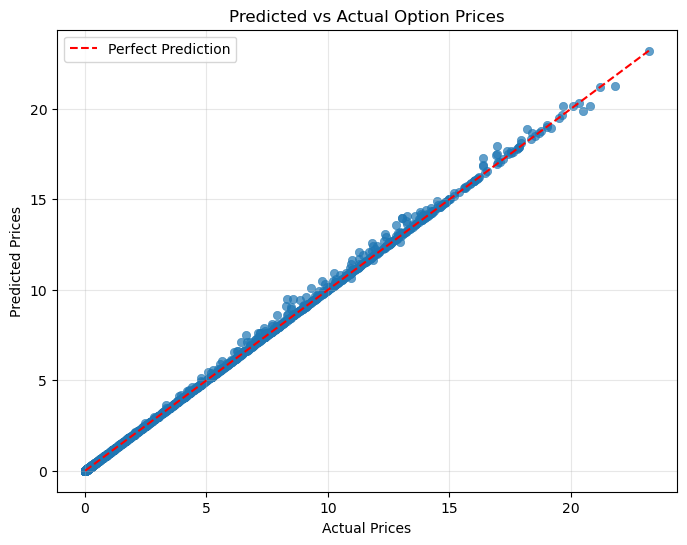

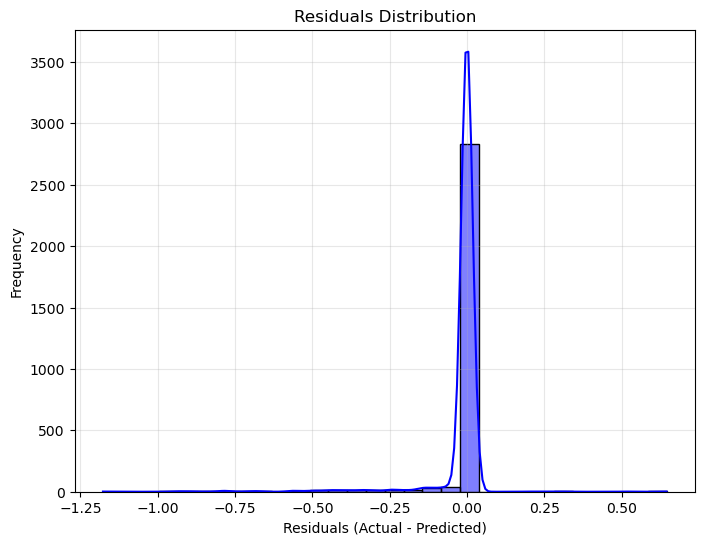

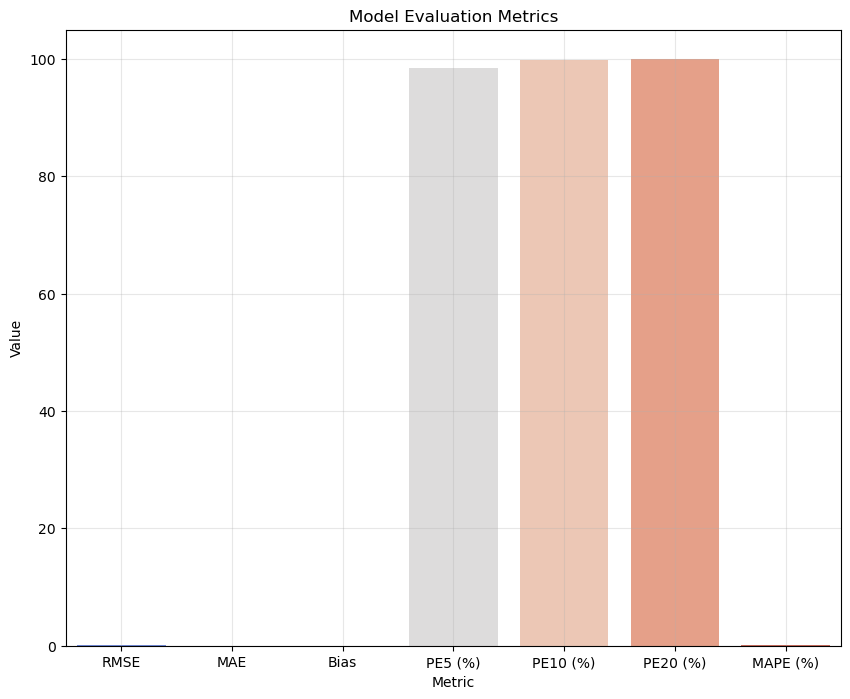

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------- Plotting Functions ------------------- #

def plot_predictions_vs_actual(df, actual_col, predicted_col):
    """
    Plot the predicted option prices against actual prices.
    """
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=df[actual_col], y=df[predicted_col], alpha=0.7, edgecolor=None)
    plt.plot([df[actual_col].min(), df[actual_col].max()], 
             [df[actual_col].min(), df[actual_col].max()], 
             color="red", linestyle="--", label="Perfect Prediction")
    plt.title("Predicted vs Actual Option Prices")
    plt.xlabel("Actual Prices")
    plt.ylabel("Predicted Prices")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

def plot_residuals(df, actual_col, predicted_col):
    """
    Plot the residuals (errors) of the predictions.
    """
    residuals = df[actual_col] - df[predicted_col]
    plt.figure(figsize=(8, 6))
    sns.histplot(residuals, kde=True, color="blue", bins=30)
    plt.title("Residuals Distribution")
    plt.xlabel("Residuals (Actual - Predicted)")
    plt.ylabel("Frequency")
    plt.grid(alpha=0.3)
    plt.show()

def plot_metrics(metrics_dict):
    """
    Visualize metrics using a bar plot.
    """
    metrics_df = pd.DataFrame([metrics_dict])
    metrics_df = metrics_df.melt(var_name="Metric", value_name="Value")
    
    plt.figure(figsize=(10, 8))
    sns.barplot(data=metrics_df, x="Metric", y="Value", palette="coolwarm")
    plt.title("Model Evaluation Metrics")
    plt.ylabel("Value")
    plt.grid(alpha=0.3)
    plt.show()

# ------------------- Example Usage ------------------- #

# Plot predicted vs actual prices
plot_predictions_vs_actual(euro_options, actual_col="premium", predicted_col="bs")

# Plot residuals
plot_residuals(euro_options, actual_col="premium", predicted_col="bs")

# Plot metrics
plot_metrics(metrics)


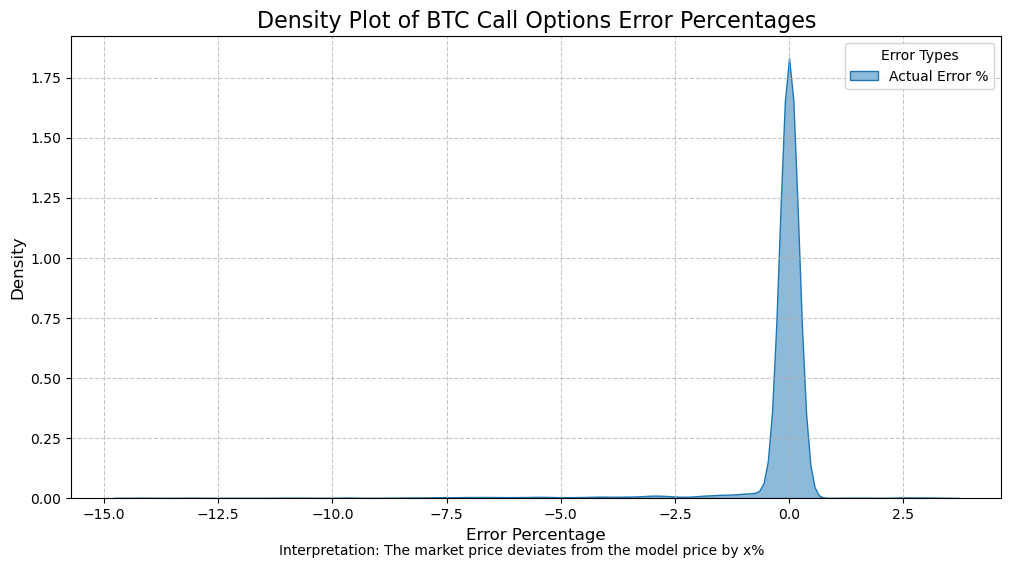

In [5]:
# Copy the original dataframe
btc_call_options = euro_options.copy()

# Calculate errors with safety checks
btc_call_options["Actual Error %"] = (
    (btc_call_options["premium"] - btc_call_options["bs"]) 
    / btc_call_options["premium"]
) * 100

# Remove infinite and NaN values
btc_call_options = btc_call_options[
    np.isfinite(btc_call_options["Actual Error %"])]

# Set up the plot
plt.figure(figsize=(12, 6))

# Create density plots
sns.kdeplot(data=btc_call_options, x="Actual Error %", label="Actual Error %", fill=True, alpha=0.5)

# Customize the plot
plt.title("Density Plot of BTC Call Options Error Percentages", fontsize=16)
plt.xlabel("Error Percentage", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.legend(title="Error Types")
plt.grid(True, linestyle='--', alpha=0.7)
plt.figtext(0.5, 0.01, 'Interpretation: The market price deviates from the model price by x%', ha='center', va='bottom', fontsize=10)
plt.show()

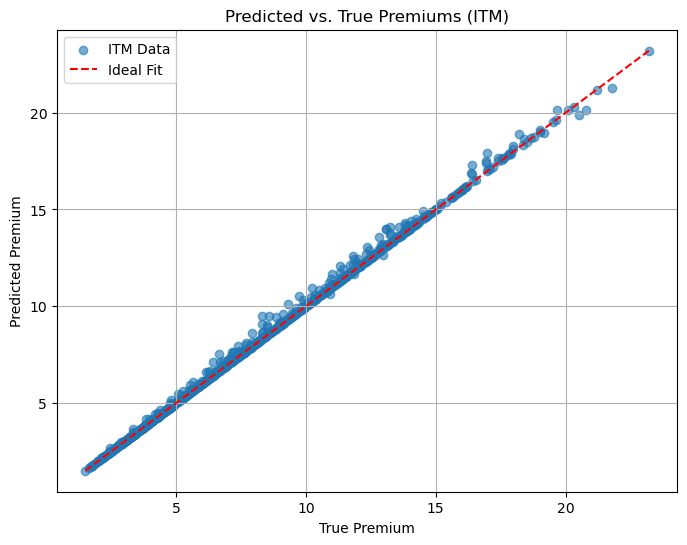

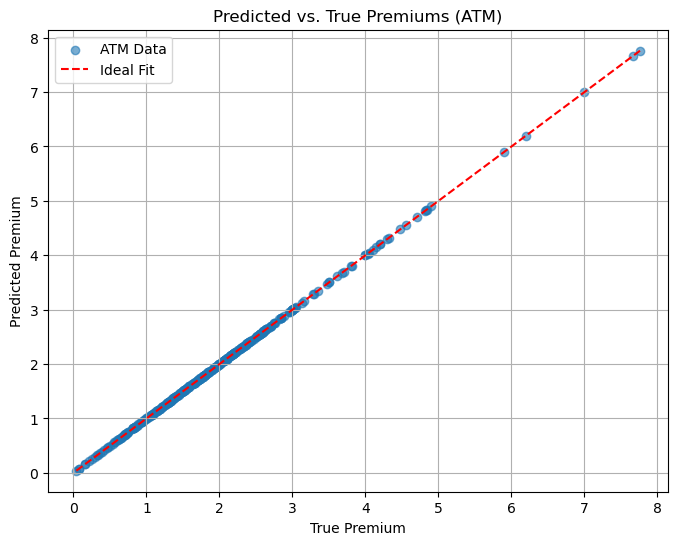

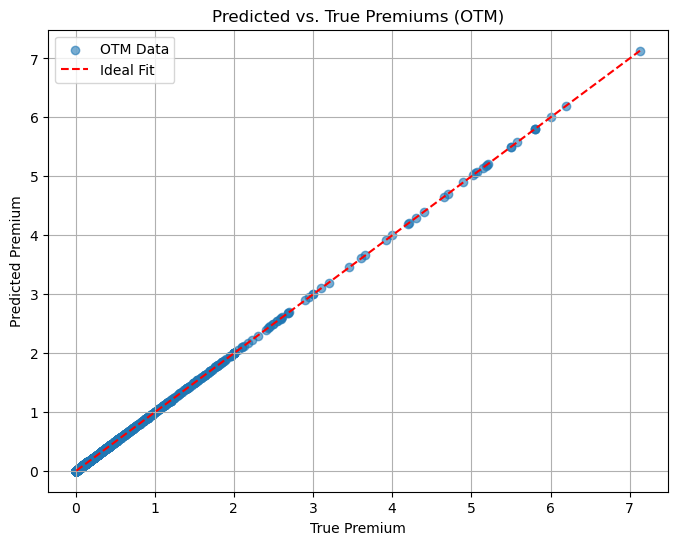

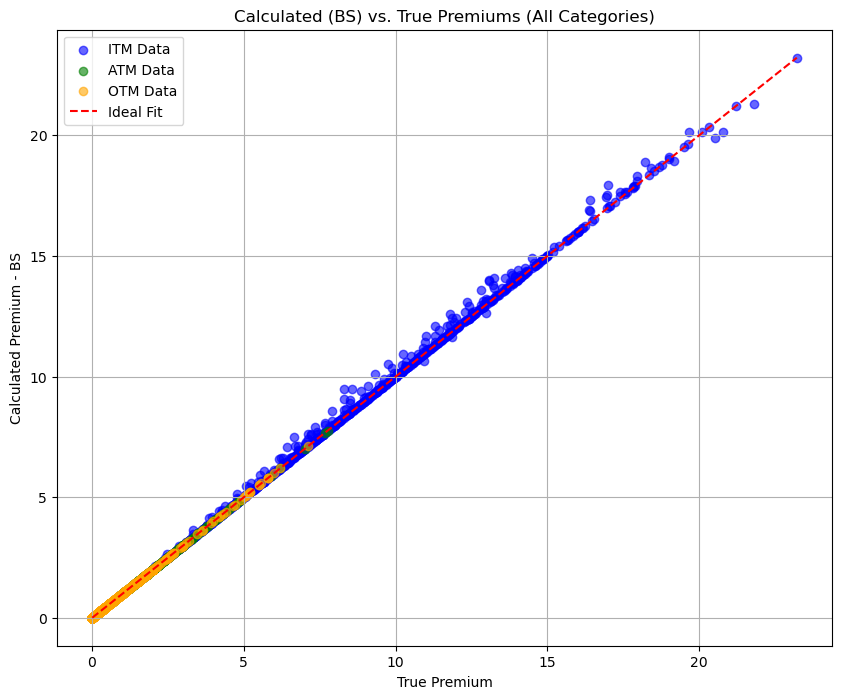

In [6]:
# Define a helper function to plot predicted vs true prices for each category
itm_options = euro_options[euro_options["moneyness"] == "ITM"]
atm_options = euro_options[euro_options["moneyness"] == "ATM"]
otm_options = euro_options[euro_options["moneyness"] == "OTM"]

def plot_predicted_vs_true(data, category_name):
    plt.figure(figsize=(8, 6))
    plt.scatter(data["premium"], data["bs"], alpha=0.6, label=f'{category_name} Data')
    plt.plot([data["premium"].min(), data["premium"].max()],
             [data["premium"].min(), data["premium"].max()],
             color='red', linestyle='--', label='Ideal Fit')
    plt.title(f"Predicted vs. True Premiums ({category_name})")
    plt.xlabel("True Premium")
    plt.ylabel("Predicted Premium")
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot results for ITM, ATM, and OTM separately
plot_predicted_vs_true(itm_options, "ITM")
plot_predicted_vs_true(atm_options, "ATM")
plot_predicted_vs_true(otm_options, "OTM")

# Plot combined results for all moneyness categories
plt.figure(figsize=(10, 8))
plt.scatter(itm_options["premium"], itm_options["bs"], alpha=0.6, label='ITM Data', color='blue')
plt.scatter(atm_options["premium"], atm_options["bs"], alpha=0.6, label='ATM Data', color='green')
plt.scatter(otm_options["premium"], otm_options["bs"], alpha=0.6, label='OTM Data', color='orange')
plt.plot([euro_options["premium"].min(), euro_options["premium"].max()],
         [euro_options["premium"].min(), euro_options["premium"].max()],
         color='red', linestyle='--', label='Ideal Fit')
plt.title("Calculated (BS) vs. True Premiums (All Categories)")
plt.xlabel("True Premium")
plt.ylabel("Calculated Premium - BS")
plt.legend()
plt.grid(True)
plt.show()


In [7]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def evaluate_model(true, predicted, model_name):
    mse = mean_squared_error(true, predicted)
    mae = mean_absolute_error(true, predicted)
    r2 = r2_score(true, predicted)
    mape = np.mean(np.abs((true - predicted) / true)) * 100  # Calculate MAPE
    
    print(f"\n{model_name} Performance:")
    print(f"  MSE: {mse}")
    print(f"  MAE: {mae}")
    print(f"  R^2: {r2}")
    print(f"  MAPE: {mape:.2f}%")

# ITM Metrics
itm_mape = mean_absolute_percentage_error(itm_options["premium"], itm_options["bs"])
itm_mse = mean_squared_error(itm_options["premium"], itm_options["bs"])
itm_r2 = r2_score(itm_options["premium"], itm_options["bs"])
print(f"ITM - MAPE: {itm_mape:.2%}, MSE: {itm_mse:.4f}, RMSE: {np.sqrt(itm_mse):.4f}, R^2: {itm_r2:.4f}")

# ATM Metrics
atm_mape = mean_absolute_percentage_error(atm_options["premium"], atm_options["bs"])
atm_mse = mean_squared_error(atm_options["premium"], atm_options["bs"])
atm_r2 = r2_score(atm_options["premium"], atm_options["bs"])
print(f"ATM - MAPE: {atm_mape:.2%}, MSE: {atm_mse:.4f}, RMSE: {np.sqrt(atm_mse):.4f}, R^2: {atm_r2:.4f}")

# OTM Metrics
otm_mape = mean_absolute_percentage_error(otm_options["premium"], otm_options["bs"])
otm_mse = mean_squared_error(otm_options["premium"], otm_options["bs"])
otm_r2 = r2_score(otm_options["premium"], otm_options["bs"])
print(f"OTM - MAPE: {otm_mape:.4%}, MSE: {otm_mse:.4f}, RMSE: {np.sqrt(otm_mse):.4f}, R^2: {otm_r2:.4f}")


ITM - MAPE: 57.80%, MSE: 0.0258, RMSE: 0.1607, R^2: 0.9985
ATM - MAPE: 0.05%, MSE: 0.0000, RMSE: 0.0001, R^2: 1.0000
OTM - MAPE: 0.0000%, MSE: 0.0000, RMSE: 0.0000, R^2: 1.0000
